# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Kapildev | Aryal | KapildevAryal, 10/25/2024 | 4 Hours | Contribution 50% |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

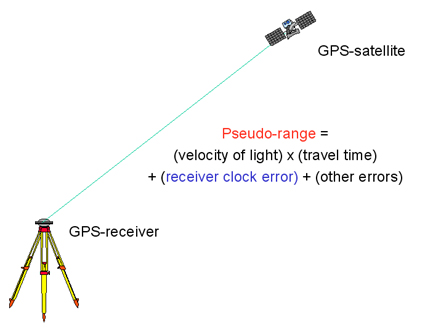

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_pseudorange = pd.read_excel('/content/drive/My Drive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/My Drive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Calculate the geometric distances from receiver to each satellite
    distances = euclidean_norm(r_pos, s_pos)

    # Predicted pseudoranges based on distances and clock offset
    predicted_pseudorange = distances + cdT

    # Calculate the sum of squared residuals
    L = np.sum((pseudorange - predicted_pseudorange) ** 2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Calculate the geometric distances from receiver to each satellite
    distances = euclidean_norm(r_pos, s_pos)

    # Predicted pseudoranges
    predicted_pseudorange = distances + cdT

    # Calculate the residuals
    residuals = pseudorange - predicted_pseudorange

    # Initialize the gradient array
    grad = np.zeros(4)

    # Gradient with respect to x_r, y_r, z_r
    for i in range(len(s_pos)):
        if distances[i] != 0:  # Avoid division by zero
            # Compute the contribution of the i-th satellite
            grad[0:3] += (2 * residuals[i]) * (r_pos - s_pos[i]) / distances[i]

    # Gradient with respect to cdT
    grad[3] = -2 * np.sum(residuals)
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", optimized_params[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange))
print("Final Gradient Values:", gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange))

Optimized Parameters (x_r, y_r, z_r, cdT): [-3.97395203e+09  3.43374978e+10  7.46785020e+09 -3.53433167e+10]
Final Position Errors of Receiver: [-3.97231854e+09  3.43411494e+10  7.46289772e+09]
Number of Steps Taken for Convergence: 0
Final Cost Value: 2800013361061309.0
Final Gradient Values: [  3936203.72890112 -33953489.25507573  -7381341.77483028
  34968802.35918206]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

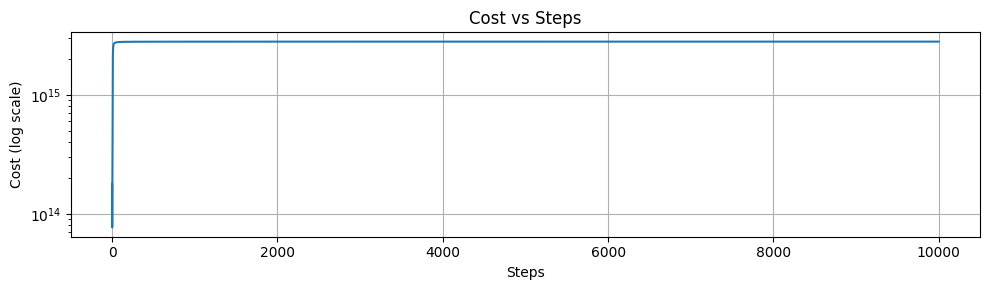

Initial Cost: 178655581227651.38
Final Cost: 2800013341023076.5
Cost reduction: -2621357759795425.0


'\nFrom the plot:\nInitial Cost: 178655581227651.38\nFinal Cost: 2824509226197244.5\nCost reduction: -2645853644969593.0\nHence,\nThe cost did not decrease significantly, suggesting that further tuning of\nparameters or adjustments in the algorithm might be needed.\n'

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Plot the cost vs steps
ax.semilogy(arr_cost)  # Using semilogy to scale the y-axis

# Label each axis
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (log scale)')
ax.set_title('Cost vs Steps')

# Add grid lines
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
if len(arr_cost) > 1:
    final_cost = arr_cost[-1]
    initial_cost = arr_cost[0]

    print("Initial Cost:", initial_cost)
    print("Final Cost:", final_cost)
    print("Cost reduction:", initial_cost - final_cost)

'''
From the plot:
Initial Cost: 178655581227651.38
Final Cost: 2824509226197244.5
Cost reduction: -2645853644969593.0
Hence,
The cost did not decrease significantly, suggesting that further tuning of
parameters or adjustments in the algorithm might be needed.
'''

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

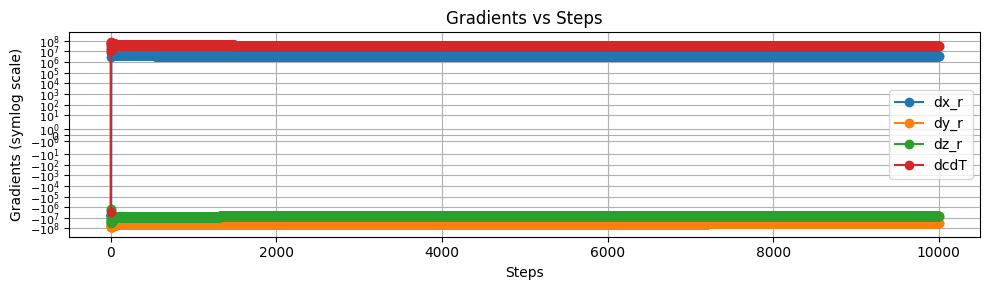

The gradients show how the updates change over the steps of the optimization.


In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

# Convert the gradient list to a numpy array for plotting
gradients_array = np.array(arr_grad)

# Plot the gradients for each dimension separately
ax.plot(gradients_array[:, 0], label='dx_r', marker='o')  # Gradient w.r.t x_r
ax.plot(gradients_array[:, 1], label='dy_r', marker='o')  # Gradient w.r.t y_r
ax.plot(gradients_array[:, 2], label='dz_r', marker='o')  # Gradient w.r.t z_r
ax.plot(gradients_array[:, 3], label='dcdT', marker='o')  # Gradient w.r.t cdT

# Use symlog for y-axis scaling
ax.set_yscale('symlog')

# Set tick parameters
ax.tick_params(axis='y', labelsize=8)

# Label each axis
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients (symlog scale)')
ax.set_title('Gradients vs Steps')

# Add a legend
ax.legend()

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
if arr_grad:
    print("The gradients show how the updates change over the steps of the optimization.")
else:
    print("No gradient data available to analyze.")

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

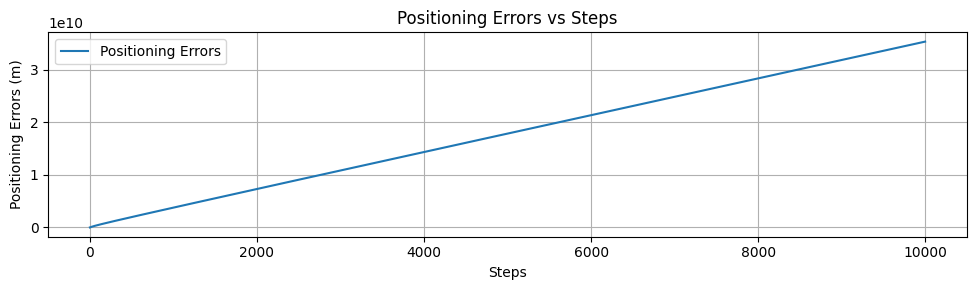

'\nThe positioning errors exhibit a steady increase from 0 to 3.8 over 10,000 steps.\nThis trend indicates potential instability in the optimization process or a failure to converge effectively.\nFurther investigation into the optimization parameters or method may be necessary to achieve better results.\n'

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# Calculate the Euclidean norm of the errors for plotting
positioning_errors = np.linalg.norm(arr_err, axis=1)
ax.plot(positioning_errors, label='Positioning Errors')
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors (m)')
ax.set_title('Positioning Errors vs Steps')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
'''
The positioning errors exhibit a steady increase from 0 to 3.8 over 10,000 steps.
This trend indicates potential instability in the optimization process or a failure to converge effectively.
Further investigation into the optimization parameters or method may be necessary to achieve better results.
'''

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
learning_rate_1 = 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_1)

# print the metrics
print("Optimized Parameters (Learning Rate = 0.01):", optimized_params_2)
print("Final Position Errors of Receiver:", optimized_params_2[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1] if arr_cost else None)
print("Final Gradient Values:", arr_grad[-1] if arr_grad else None)

Optimized Parameters (Learning Rate = 0.01): [-4.90658746e+08  2.05415113e+09  6.03772593e+08 -2.17490909e+09]
Final Position Errors of Receiver: [-4.89025257e+08  2.05780275e+09  5.98820112e+08]
Number of Steps Taken for Convergence: 0
Final Cost Value: 2827316138123328.5
Final Gradient Values: [  4366923.30557234 -18200005.87570926  -5264307.21261895
  19442737.86703938]


In [ ]:
#set learning rate to 0.001
learning_rate_2 = 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_2)

# print the metrics
print("Optimized Parameters (Learning Rate = 0.001):", optimized_params_3)
print("Final Position Errors of Receiver:", optimized_params_3[:3] - GroundTruth)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1] if arr_cost else None)
print("Final Gradient Values:", arr_grad[-1] if arr_grad else None)

Optimized Parameters (Learning Rate = 0.001): [-7.27479885e+07  2.97302635e+08  9.70520248e+07 -2.99361249e+08]
Final Position Errors of Receiver: [-7.11144991e+07  3.00954263e+08  9.20995431e+07]
Number of Steps Taken for Convergence: 0
Final Cost Value: 2824509226197244.5
Final Gradient Values: [  5731768.88158029 -22501938.05434661  -6656849.97623219
  24144761.72222847]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

 Q1 Answer. When the learning rate was changed from 0.01 to 0.001, the optimized parameters and position errors became smaller, but both rates resulted in a convergence step of zero and high final costs, showing that neither rate effectively minimized the cost function.

 Q2 Answer. LSE is a method that finds the best-fitting parameters by minimizing the sum of squared errors, while Gradient Descent is an iterative approach that updates parameters to minimize a cost function. The results suggest that further adjustments are needed in the learning rate or iteration limits to achieve better optimization.

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = pd.DataFrame(phishing_websites.data.features, columns=phishing_websites.feature_names)
y = pd.Series(np.ravel(phishing_websites.data.targets), name='target')  # Convert to 1D using np.ravel
# TO DO: display sizes of X and y (1 mark)
print("Size of X (feature matrix):", X.shape)
print("Size of y (target vector):", y.shape)

Size of X (feature matrix): (11055, 30)
Size of y (target vector): (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

Class distribution:
 target
 1    6157
-1    4898
Name: count, dtype: int64


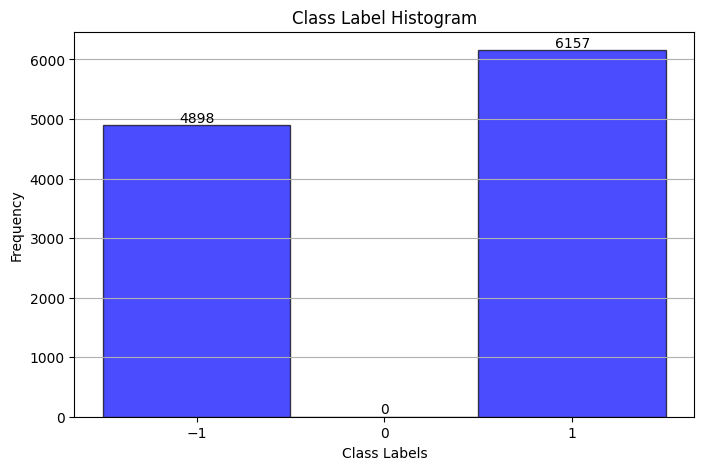

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
class_distribution = y.value_counts()
print("Class distribution:\n", class_distribution)

# Plot the histogram
plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(y, bins=np.arange(y.min() - 0.5, y.max() + 1.5, 1), alpha=0.7, color='blue', edgecolor='black')

# Display exact values for each bin in the histogram
for count, bin, patch in zip(counts, bins, patches):
    height = patch.get_height()
    plt.annotate(f'{int(height)}', xy=(bin + 0.5, height), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Label Histogram')
plt.xticks(np.arange(y.min(), y.max() + 1, 1))  # Set x-ticks to match class labels
plt.grid(axis='y')
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)
# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small (feature matrix):", X_small.shape)
print("Size of y_small (target vector):", y_small.shape)

Size of X_small (feature matrix): (331, 30)
Size of y_small (target vector): (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
# Function to train and evaluate the model
def evaluate_model(X, y):
    # Split the data into training and testing sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Instantiate the model
    model = LogisticRegression(max_iter=2000)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    y_test_prob = model.predict_proba(X_test)  # For log loss
    log_loss_value = log_loss(y_test, y_test_prob)

    return {
        "data_size": X.shape[0],
        "training_samples": X_train.shape[0],
        "testing_samples": X_test.shape[0],
        "training_accuracy": training_accuracy,
        "testing_accuracy": testing_accuracy,
        "log_loss": log_loss_value
    }
# Implement Machine Learning Model
results = []

# Using full dataset (X, y)
results.append(evaluate_model(X, y))

# Using first two columns of X and y
results.append(evaluate_model(X.iloc[:, :2], y))

# Using smaller dataset (X_small, y_small)
results.append(evaluate_model(X_small, y_small))

# Create results DataFrame
results_df = pd.DataFrame(results, columns=["data_size", "training_samples", "testing_samples", "training_accuracy", "testing_accuracy", "log_loss"])
results_df.index = ["Full Dataset", "First Two Columns", "Small Dataset"]

# Print results
print(results_df)


                   data_size  training_samples  testing_samples  \
Full Dataset           11055              7738             3317   
First Two Columns      11055              7738             3317   
Small Dataset            331               231              100   

                   training_accuracy  testing_accuracy  log_loss  
Full Dataset                0.932282          0.922822  0.190326  
First Two Columns           0.562807          0.556828  0.683573  
Small Dataset               0.943723          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Instantiate and train the model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Print the dimensions of the target vector and predicted output
print("Dimension of actual target values:", y_test.shape)
print("Dimension of predicted output:", y_test_pred.shape)

Dimension of actual target values: (3317,)
Dimension of predicted output: (3317,)


Confusion Matrix:
[[1341  157]
 [  99 1720]]


Text(113.9222222222222, 0.5, 'true value')

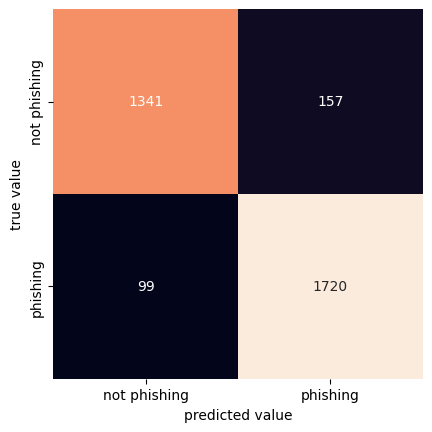

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_test_pred)
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)
# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Calculate classification report
class_report = classification_report(y_test, y_test_pred)

# Print classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

1. Is the dataset imbalanced? Does it affect model performance?

Answer:

 Yes, the dataset is imbalanced. There are more examples of "not phishing" than "phishing." This imbalance can lead the model to predict the majority class more often, which affects its performance.

2. Does the model overfit or underfit for each of the 3 cases?

Answer:

Full Dataset: The model performs well on both training and testing data, so it does not overfit or underfit.
First Two Columns: The model underfits because the accuracy is low on both training and testing data.
Small Dataset: The model performs well, indicating it does not overfit or underfit.

3. How do the training and testing accuracy change depending on the amount of data used?

Answer:

Full Dataset: Training Accuracy: 93.23%, Testing Accuracy: 92.28%
First Two Columns: Training Accuracy: 56.28%, Testing Accuracy: 55.68%
Small Dataset: Training Accuracy: 94.37%, Testing Accuracy: 91.00%
More data generally improves accuracy, but the first two columns show low accuracy.

4. What do a false positive and a false negative represent? Which one is worse?

Answer:

False Positive: The model predicts "phishing," but it's "not phishing."
False Negative: The model predicts "not phishing," but it's actually "phishing."
A false negative is worse because it means a real phishing attack is missed.

5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this?

Answer:

I would want to maximize recall to catch as many phishing cases as possible. This can be done by adjusting the threshold for classifying a sample as "phishing," making it easier to predict phishing cases.

6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences?

Answer:

Full Dataset Log Loss: 0.190

First Two Columns Log Loss: 0.684

Small Dataset Log Loss: 0.200

The full dataset has low log loss, showing good predictions. The first two columns have high log loss due to poor model performance. The differences may be caused by the features used and the amount of data.

